
I recently stumbled on this interesting post on [RealPython](https://realpython.com/) (excellent website by the way!):

[**Fast, Flexible, Easy and Intuitive: How to Speed Up Your Pandas Projects**](https://realpython.com/fast-flexible-pandas/)

This post has different subjects related to Pandas:
- creating a `datetime` column
- looping over Pandas data
- saving/loading HDF data stores
- ...

I focused on the *looping over Pandas data* part. They compare different approaches for looping over a dataframe and applying a basic (piecewise linear) function: 
- a "crappy" loop with `.iloc` to access the data
- `iterrows()`
- `apply()` with a lambda function

But I was a little bit disapointed to see that they did not actually implement the following other approaches:
- itertuples()`
> While `.itertuples()` tends to be a bit faster, let’s stay in Pandas and use `.iterrows()` in this example, because some readers might not have run across `nametuple`. 
- Numpy vectorize
- Numpy (just a loop over Numpy vectors)
- Cython
- Numba

So I just wanted to complete their post by adding the latter approaches to the performance comparison, using the same `.csv` file. In order to compare all the different implementations on the same computer, I also copied and re-ran their code.  

Note: my laptop CPU is an `Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz`  (with some DDDR4-2400 RAM).

## Imports

In [1]:
import sys
print(f"Python version: {sys.version}")

import numpy as np
print(f"Numpy version: {np.__version__}")

import pandas as pd
print(f"Pandas version: {pd.__version__}")

%load_ext Cython
import cython
print(f"Cython version: {cython.__version__}")

import numba
print(f"Numba version: {numba.__version__}")
from numba import jit

import dask
print(f"Dask version: {dask.__version__}")
import dask.dataframe as dd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

Python version: 3.7.0 (default, Jun 28 2018, 13:15:42) 
[GCC 7.2.0]
Numpy version: 1.15.0
Pandas version: 0.23.3
Cython version: 0.28.4
Numba version: 0.39.0
Dask version: 0.18.2


## Load the csv file

The `.csv` file is located [here](https://github.com/realpython/materials/blob/master/pandas-fast-flexible-intuitive/tutorial/demand_profile.csv). It has been saved in a local `data/` directory. The `datetime` column is created at the import with the `parse_dates` argument.

In [2]:
df = pd.read_csv('./data/demand_profile.csv', parse_dates=['date_time'])
df.info()  # inspect the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 2 columns):
date_time     8760 non-null datetime64[ns]
energy_kwh    8760 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 137.0 KB


So we only have two columns in this dataframe: one for the `datetime` and one for the energy usage:

In [3]:
df.head(2)

,date_time,energy_kwh
0,2013-01-01 00:00:00,0.586
1,2013-01-01 01:00:00,0.580


> The goal of this example will be to apply time-of-use energy tariffs to find the total cost of energy consumption for one year. That is, at different hours of the day, the price for electricity varies, so the task is to multiply the electricity consumed for each hour by the correct price for the hour in which it was consumed.

# Performance comparison

## 1. The "Crappy" loop

In [4]:
def apply_tariff(kwh, hour):
    """ Calculates cost of electricity for given hour.
    """

    if 0 <= hour < 7:
        rate = 12
    elif 7 <= hour < 17:
        rate = 20
    elif 17 <= hour < 24:
        rate = 28
    else:
        raise ValueError(f'Invalid hour: {hour}')

    return rate * kwh

In [5]:
def apply_tariff_loop(df):
    """ Calculate costs in loop.  Modifies `df` inplace.
    """

    energy_cost_list = []
    for i in range(len(df)):
        # Get electricity used and hour of day
        energy_used = df.iloc[i]['energy_kwh']
        hour = df.iloc[i]['date_time'].hour
        energy_cost = apply_tariff(energy_used, hour)
        energy_cost_list.append(energy_cost)
    df['cost_cents'] = energy_cost_list

In [6]:
timeit = {}  # initialization of the timing measures
result = %timeit -r 1 -n 1 -o apply_tariff_loop(df)
timeit["Crappy Loop"] = result.best

1.91 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Next we save the result of the computation in order to later check that we get the same result with the different implementations...

In [7]:
df.rename(columns={'cost_cents': 'cost_cents_ref'}, inplace=True)

## 2. Looping with `.iterrows()`

In [8]:
def apply_tariff_iterrows(df):

    energy_cost_list = []
    for index, row in df.iterrows():
        # Get electricity used and hour of day
        energy_used = row['energy_kwh']
        hour = row['date_time'].hour
        # Append cost list
        energy_cost = apply_tariff(energy_used, hour)
        energy_cost_list.append(energy_cost)
    df['cost_cents'] = energy_cost_list

In [9]:
result = %timeit -r 3 -n 10 -o apply_tariff_iterrows(df)
timeit['Iterrows'] = result.best

533 ms ± 72.4 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [10]:
assert np.allclose(df.cost_cents.values, df.cost_cents_ref.values)
df.drop('cost_cents', axis=1, inplace=True)

## 3. `.iterrows()` with row-wise element insertion

In [11]:
def apply_tariff_iterrows_rwei(df):

    df['cost_cents'] = 0.0
    for index, row in df.iterrows():
        # Get electricity used and hour of day
        energy_used = row['energy_kwh']
        hour = row['date_time'].hour
        # Append cost list
        energy_cost = apply_tariff(energy_used, hour)
        df.at[index, 'cost_cents'] = energy_cost

In [12]:
result = %timeit -r 3 -n 10 -o apply_tariff_iterrows_rwei(df)
timeit['Iterrows_RWEI'] = result.best

782 ms ± 82.6 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [13]:
assert np.allclose(df.cost_cents.values, df.cost_cents_ref.values)
df.drop('cost_cents', axis=1, inplace=True)

## 4. Pandas’ `apply()`

In [14]:
def apply_tariff_withapply(df):

    df['cost_cents'] = df.apply(
        lambda row: apply_tariff(
            kwh=row['energy_kwh'],
            hour=row['date_time'].hour),
        axis=1)

In [15]:
result = %timeit -r 3 -n 10 -o apply_tariff_withapply(df)
timeit['Apply'] = result.best

191 ms ± 6.69 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [16]:
assert np.allclose(df.cost_cents.values, df.cost_cents_ref.values)
df.drop('cost_cents', axis=1, inplace=True)

## 5. Looping with `.itertuples()`

In [17]:
def apply_tariff_itertuples(df):

    energy_cost_list = []
    for row in df.itertuples():
        # Get electricity used and hour of day
        energy_used = row.energy_kwh
        hour = row.date_time.hour
        # Append cost list
        energy_cost = apply_tariff(energy_used, hour)
        energy_cost_list.append(energy_cost)
    df['cost_cents'] = energy_cost_list

In [18]:
result = %timeit -r 3 -n 10 -o apply_tariff_itertuples(df)
timeit['Itertuples'] = result.best

39.7 ms ± 4.61 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [19]:
assert np.allclose(df.cost_cents.values, df.cost_cents_ref.values)
df.drop('cost_cents', axis=1, inplace=True)

## 6. Looping with Dask `.itertuples()

In [20]:
def apply_tariff_itertuples_dask(df_dask):

    energy_cost_list = []
    for row in df_dask.itertuples():
        # Get electricity used and hour of day
        energy_used = row.energy_kwh
        hour = row.date_time.hour
        # Append cost list
        energy_cost = apply_tariff(energy_used, hour)
        energy_cost_list.append(energy_cost)
    energy_cost = pd.Series(energy_cost_list)
    return df_dask.assign(cost_cents = energy_cost)

In [21]:
df_dask = dd.from_pandas(df, npartitions=1)

In [22]:
result = %timeit -r 3 -n 10 -o apply_tariff_itertuples_dask(df_dask)
timeit['Dask itertuples 4'] = result.best

45.7 ms ± 1.84 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [23]:
df_dask = apply_tariff_itertuples_dask(df_dask)

In [24]:
assert np.allclose(df_dask.cost_cents.values, df.cost_cents_ref.values)

## 7. Numpy's `vectorize()`

In [25]:
def apply_tariff_vect(hour, kwh):

    if 0 <= hour < 7:
        rate = 12
    elif 7 <= hour < 17:
        rate = 20
    else:
        rate = 28

    return rate * kwh

vfunc = np.vectorize(apply_tariff_vect)

def compute_cost_vect(df):

    df['cost_cents'] = 0.0
    hour_array = df.date_time.dt.hour.values
    if (hour_array.min() < 0) or (hour_array.max() > 23):
        raise ValueError(f'Invalid hour values')

    df.cost_cents = vfunc(hour_array, df.energy_kwh.values)

In [26]:
result = %timeit -r 3 -n 10 -o compute_cost_vect(df)
timeit['Numpy vectorize'] = result.best

2.93 ms ± 247 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [27]:
assert np.allclose(df.cost_cents.values, df.cost_cents_ref.values)
df.drop('cost_cents', axis=1, inplace=True)

## 8. The Numpy loop

Before testing Cython and Numba, let's create a loop function `loop_tariff` with Numpy array arguments, on which we are going to apply the different methods.

In [28]:
def loop_tariff(hour_array, energy_kwh_array, cost_cents_array):

    df_len = hour_array.shape[0]

    for i in range(df_len):
        hour = hour_array[i]
        if 0 <= hour < 7:
            rate = 12
        elif 7 <= hour < 17:
            rate = 20
        else:
            rate = 28
        cost_cents_array[i] = rate * energy_kwh_array[i]
        
def compute_cost(df):

    df['cost_cents'] = 0.0
    hour_array = df.date_time.dt.hour.values
    if (hour_array.min() < 0) or (hour_array.max() > 23):
        raise ValueError(f'Invalid hour values')

    loop_tariff(hour_array, df.energy_kwh.values, df.cost_cents.values)

In [29]:
result = %timeit -r 3 -n 10 -o compute_cost(df)
timeit['Numpy loop'] = result.best

8.58 ms ± 325 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [30]:
assert np.allclose(df.cost_cents.values, df.cost_cents_ref.values)
df.drop('cost_cents', axis=1, inplace=True)

## 9. Cython

In [31]:
%%cython

cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False) 
cdef loop_tariff_cython(long[:] hour_array, double[:] energy_kwh_array, double[:] cost_cents_array):

    cdef: 
        int i, rate
        long hour
        int df_len = hour_array.shape[0]

    for i in range(df_len):
        hour = hour_array[i]
        if 0 <= hour < 7:
            rate = 12
        elif 7 <= hour < 17:
            rate = 20
        else:
            rate = 28
        cost_cents_array[i] = rate * energy_kwh_array[i]
        
        
cpdef compute_cost_cython(df):

    df['cost_cents'] = 0.0
    hour_array = df.date_time.dt.hour.values
    if (hour_array.min() < 0) or (hour_array.max() > 23):
        raise ValueError(f'Invalid hour values')

    loop_tariff_cython(hour_array, df.energy_kwh.values, df.cost_cents.values)

In [32]:
result = %timeit -r 3 -n 100 -o compute_cost_cython(df)
timeit['Cython'] = result.best

1.01 ms ± 148 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [33]:
assert np.allclose(df.cost_cents.values, df.cost_cents_ref.values)
df.drop('cost_cents', axis=1, inplace=True)

Run time is too short to try multithreading the Cython loop with openMP. However that would be very interesting to try on a larger dataframe with heavier computations performed inside the loop.

## 10. Numba

In [34]:
def loop_tariff_numba(hour_array, energy_kwh_array, cost_cents_array):

    df_len = hour_array.shape[0]

    for i in range(df_len):
        hour = hour_array[i]
        if 0 <= hour < 7:
            rate = 12
        elif 7 <= hour < 17:
            rate = 20
        else:
            rate = 28
        cost_cents_array[i] = rate * energy_kwh_array[i]

loop_tariff_numba = jit(loop_tariff_numba)
        
def compute_cost_numba(df):

    df['cost_cents'] = 0.0
    hour_array = df.date_time.dt.hour.values
    if (hour_array.min() < 0) or (hour_array.max() > 23):
        raise ValueError(f'Invalid hour values')

    loop_tariff_numba(hour_array, df.energy_kwh.values, df.cost_cents.values)

In [35]:
result = %timeit -r 3 -n 100 -o compute_cost_numba(df)
timeit['Numba'] = result.best

1.32 ms ± 520 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [36]:
assert np.allclose(df.cost_cents.values, df.cost_cents_ref.values)
df.drop('cost_cents', axis=1, inplace=True)

## Conclusion

Well we have many options to loop over Pandas data (we did not try them all!) and a large range of performance results: from 0.0005s to 2s for some very simple computations.

At first I would use Pandas' `.itertuples()` when prototyping a code. This is rather intuitive and efficient. Then, if I notice that a huge amount of time is spent on the loop part, I would start dealing directly with Numpy arrays from the dataframe's columns. I am surprised to see how efficient is the `vectorize()` method. 

Remember that the dataframe that we are using in the present case is really small. The discrepancy observed here could correspond to many minutes on large dataframes!! However, optimizing can also take a long time or lead to complex issues...

I am really pleased to see that Numba and Cython exhibit equivalent performance! I am used to profile my code and cythonize the slow parts (using memory views to update the dataframes and openMP to multithread). But this is really more work than using Numba, for a similar reward! However, I do not know yet if you can address all kinds of problems with Numba with the same efficiency? Numba is definitely the best option when dealing with standard array-based operations. I am not sure that it can be as efficient as Cython on other data structures such as heaps for example.

Text(0.5,0,'Elapsed time (s)')

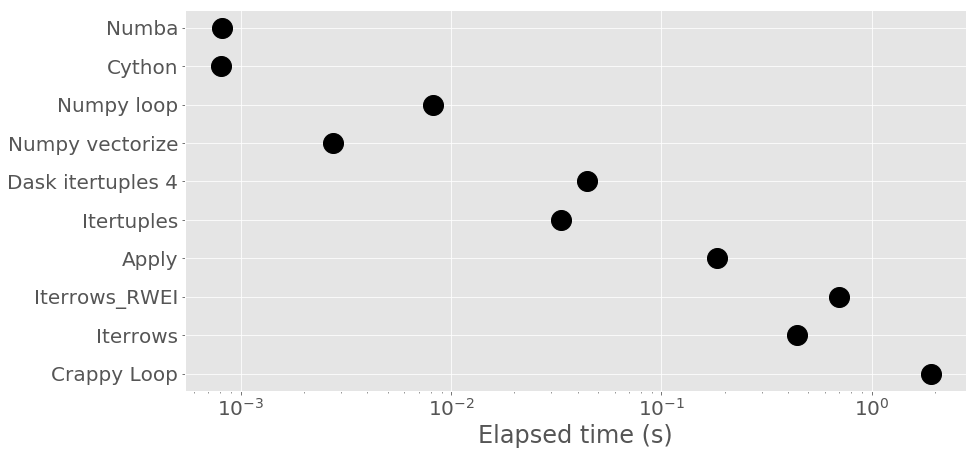

In [37]:
matplotlib.rcParams.update({'font.size': 20})
plt.figure(figsize=(14, 7))
plt.semilogx(list(timeit.values()), list(timeit.keys()), 'ko', markersize=20)
plt.xlabel("Elapsed time (s)")

In [38]:
timeit

{'Crappy Loop': 1.9076590919994487,
 'Iterrows': 0.43916611060012656,
 'Iterrows_RWEI': 0.7000513880000654,
 'Apply': 0.18414399159992173,
 'Itertuples': 0.03343178319992148,
 'Dask itertuples 4': 0.044288197899913936,
 'Numpy vectorize': 0.0027340803999322816,
 'Numpy loop': 0.008171752000089327,
 'Cython': 0.0008011818500017398,
 'Numba': 0.0008163129099921207}